In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from sklearn import metrics
from torchvision import transforms, models
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 정규화 하는 함수
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    # tqdm은 진행상태를 알려주는 함수
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()

In [4]:
im_size = 150
batch_size = 16

# 이미지 형태 변형
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])

train_data = torchvision.datasets.ImageFolder(root = '../dataset/emotion6/train', transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
mean,std = normalization_parameter(train_loader)

In [5]:
# 이미지 형태 변형
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=299),  # Image net standards
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
# 테스트 이미지는 변환 x
test_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

In [6]:
# 평균과 표준편차를 역수로 바꿈
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

In [7]:
# 이미지 데이터들의 폴더를 지정해줌
train_data = torchvision.datasets.ImageFolder(root = '../dataset/emotion6/train', transform = train_transforms)
test_data = torchvision.datasets.ImageFolder(root = '../dataset/emotion6/test', transform = test_transforms)

def data_loader(train_data,test_data = None , valid_size = None , batch_size = 32):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    
    if(test_data == None and valid_size == None):
        dataloaders = {'train':train_loader}
        return dataloaders
    
    if(test_data == None and valid_size!=None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader}
        return dataloaders
    
    ###
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        
        return dataloaders

In [8]:
dataloaders = data_loader(train_data,test_data , valid_size = 0.2 , batch_size = batch_size)
classes = train_data.classes

In [9]:
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

In [10]:
encoder

{0: 'anger', 1: 'disgust', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


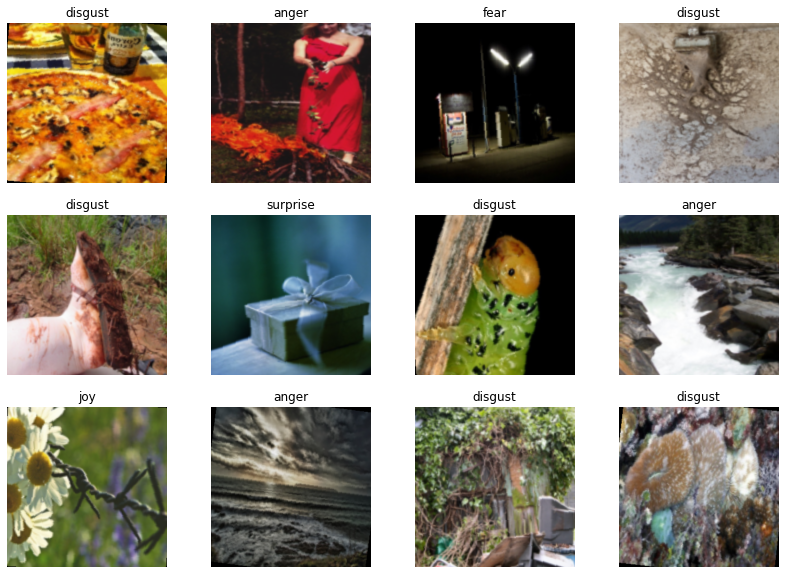

In [11]:
# 사진이 레이블링이 잘 됐나, 사진이 잘 나왔나 확인
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

In [12]:
# 모델 작성
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # pretrained model을 바꾸기 위해선 이부분을 교체
        self.resnet = models.resnet152(pretrained=True) 
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256,6)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier().to(device)

In [13]:
# 크로스 엔트로피 loss
criterion = nn.CrossEntropyLoss()

In [14]:
# 얼리스탑핑
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [15]:
# train
def train(model,dataloaders,criterion,num_epochs=10,lr=0.00001,batch_size=8,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.cuda.FloatTensor)
                target = target.type(torch.cuda.LongTensor)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('./checkpoint.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [16]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.cuda.FloatTensor)
        target = target.type(torch.cuda.LongTensor)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [17]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()
# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [18]:
def train_model(model,dataloaders,criterion,num_epochs=10,lr=0.0001,batch_size=8,patience = None,classes = None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,criterion,num_epochs,lr,batch_size,patience)
    error_plot(losses)
    acc_plot(accuracy)
    if(perform_test == True):
        true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
        wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
        performance_matrix(true,pred)
        if(classes !=None):
            plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')

Epoch: 0
train Epoch: 0  [0/1800 (0%)]	Loss: 1.929954 	Acc: 0.000000
False
val Epoch: 0  [0/180 (0%)]	Loss: 1.674676 	Acc: 0.250000
Validation loss decreased (inf --> 1.225556).  Saving model ...
False
val Accuracy:  0.22916666666666666
Epoch: 1
train Epoch: 1  [0/1800 (0%)]	Loss: 1.769418 	Acc: 0.125000
False
val Epoch: 1  [0/180 (0%)]	Loss: 1.606024 	Acc: 0.500000
Validation loss decreased (1.225556 --> 1.189579).  Saving model ...
False
val Accuracy:  0.29166666666666663
Epoch: 2
train Epoch: 2  [0/1800 (0%)]	Loss: 1.401253 	Acc: 0.437500
False
val Epoch: 2  [0/180 (0%)]	Loss: 1.425610 	Acc: 0.500000
Validation loss decreased (1.189579 --> 1.106804).  Saving model ...
False
val Accuracy:  0.3125
Epoch: 3
train Epoch: 3  [0/1800 (0%)]	Loss: 1.542008 	Acc: 0.437500
False
val Epoch: 3  [0/180 (0%)]	Loss: 1.481321 	Acc: 0.375000
EarlyStopping counter: 1 out of 10
False
val Accuracy:  0.3333333333333333
Epoch: 4
train Epoch: 4  [0/1800 (0%)]	Loss: 1.709004 	Acc: 0.375000
False
val Epoch:

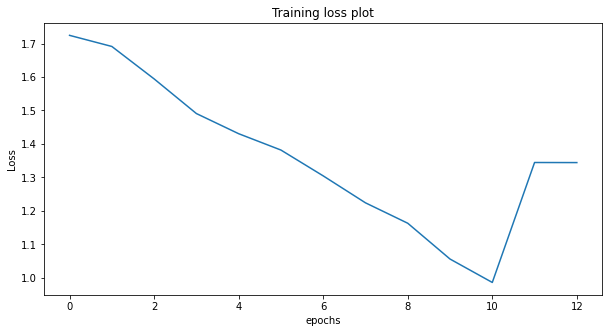

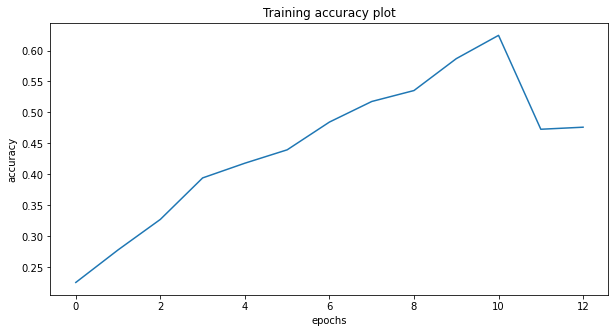

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4514, device='cuda:0', dtype=torch.float64) 1.5056788523991902
Classes in order Actual and Predicted


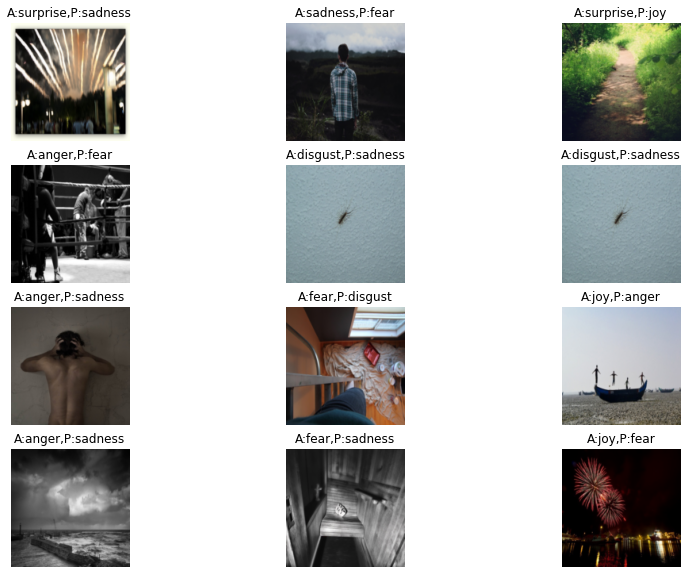

Precision: 45.56700517722023 Recall: 45.256038647343, Accuracy: 45.13888888888889: ,f1_score: 44.152910451930055
Confusion matrix, without normalization
[[ 5  2  3  2  8  4]
 [ 1 14  2  2  2  3]
 [ 1  2 11  0  5  5]
 [ 2  7  2 10  0  3]
 [ 0  2  5  1 14  1]
 [ 1  1  1  9  2 11]]


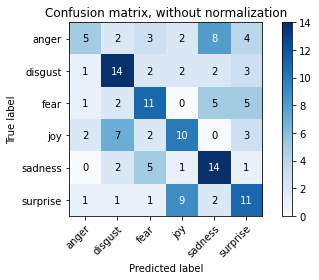

In [19]:
train_model(classifier,dataloaders,criterion,50, patience = 10 , batch_size = batch_size , classes = classes)